#**ANN in PyTorch using Functional API**

In this reading material, you'll learn how to build a simple ANN model, train it using training set,tune different hyperparameter using validation test and finally test our built model. Basically, we will be building basic ANN model in pytorch  and evaluate it.

##Prerequisites:


1.   Knowledge about commonly used functions in PyTorch.
2.   Basic workflow of an ANN model.

##Learning Objectives:


1.   Learn about terminologies related to ANN
2.   Learn how to implement a simple ANN in PyTorch using Functional API





## Implementing simple ANN using PyTorch

##1.Importing PyTorch

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

##2. Downloading dataset and Exploring the data
We start by downloading the Fashion MNIST dataset to perform classification.To download it, we use TorchVision datasets API.


In [ ]:
from torchvision import datasets
from torchvision.transforms import ToTensor

# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(), # Read file and convert image to Tensor
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

 **Dataset Split ratio :**

 Dataset split normally depends upon two things.First, the total number of samples in  data and second, on the actual model we are training.

 First , we split the data into train set and test set say, $x\%$ data is kept for test set. Remaining $(100-x)\%$ is now split into actual training set and validation set.say $y\%$ is kept for validation set then the final training set becomes $((100-x)-y)\%$ , validation set becomes $y\%$ and test set becomes $x\%$.


Here `training_data` is our **training dataset**. Training Dataset is an actual dataset that we use to train the model (weights and biases in the case of Neural Network). The model sees and learns from this data. Further split of train set into validation set and train set is done later in the code.

`test_data` is our **test dataset**. which is the sample of data used to provide an unbiased evaluation of a final model .Our model only sees the test dataset at the end, it is used as final evaluation of the model

Lets check the shape of train and test datasets.

In [ ]:
print(training_data.data.shape, training_data.targets.shape)
print(test_data.data.shape, test_data.targets.shape)

torch.Size([60000, 28, 28]) torch.Size([60000])
torch.Size([10000, 28, 28]) torch.Size([10000])


Here, `training_data.data` shape (60000,28,28) means it has 60k examples of image each of size 28*28 and `training_data.targets` shape (60000,) means it has one label for each 60k training image. Further Exploration of data is done below:

In [ ]:
print(".............1st sample data value...............")
print(training_data.data[0,10:15,10:15])
print("...............1st sample label.................")
print(training_data.targets[0])

.............1st sample data value...............
tensor([[  0,   0,   0, 193, 228],
        [  3,   0,  12, 219, 220],
        [  6,   0,  99, 244, 222],
        [  0,   0,  55, 236, 228],
        [  0,   0, 237, 226, 217]], dtype=torch.uint8)
...............1st sample label.................
tensor(9)


##Histogram plot
Now checking total number of label (class) in train dataset and plotting distribution of label in histogram.

......Total number of class is..............
10

.............Class labels are................
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

.............histogram plot of class labels............


(array([6000.,    0., 6000.,    0., 6000.,    0., 6000.,    0., 6000.,
           0.,    0., 6000.,    0., 6000.,    0., 6000.,    0., 6000.,
           0., 6000.]),
 array([0.  , 0.45, 0.9 , 1.35, 1.8 , 2.25, 2.7 , 3.15, 3.6 , 4.05, 4.5 ,
        4.95, 5.4 , 5.85, 6.3 , 6.75, 7.2 , 7.65, 8.1 , 8.55, 9.  ]),
 <a list of 20 Patch objects>)

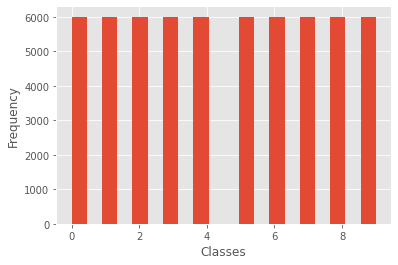

In [ ]:
import matplotlib.pyplot as plt
value = torch.unique(training_data.targets)
print("......Total number of class is..............")
print(len(value))
print("\n.............Class labels are................")
print(value)
print("\n.............histogram plot of class labels............")
plt.style.use('ggplot')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.hist(training_data.targets,bins=20)

Now we split training dataset into data for training and validation.
**Validation dataset** is the sample of data used to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters. Validation dataset is used to tune different hyperparameters so the model is unbiased. A model never learns from the validation dataset.

Here, we use `torch.utils.data.random_split` api to further split the training dataset. The output will be `Subset` where only indices of original dataset are splited.

In [ ]:
training_data, val_data = torch.utils.data.random_split(training_data, [50000, 10000])

In [ ]:
print(len(training_data.indices))
print(len(val_data.indices))

50000
10000


We can see that after the train-validation split,there are 50000 image samples in the final training set that will be used to train the model and 10000 image samples in the validation set that will be used to evaluate the model.

##3. Plotting training examples



In [ ]:
item_list = {v: k for k, v in training_data.dataset.class_to_idx.items()}
item_list

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

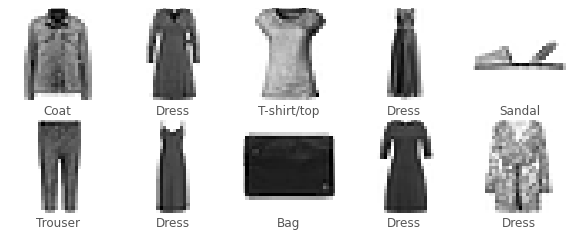

In [ ]:
# plot first few images
plt.figure(figsize=(10,10))
for i in range(10):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(training_data[i][0][0], cmap=plt.cm.binary)
  plt.xlabel(item_list[training_data[i][1]])
plt.show()

Now we create a `DataLoader` object from dataset for iterating over dataset during training and evaluation supporting automatic batching, sampling, and multiprocess data loading.

In [ ]:
batch_size = 128

from torch.utils.data import DataLoader

# we shuffle during training only
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

print(len(train_dataloader.dataset),
      len(val_dataloader.dataset),
      len(test_dataloader.dataset),)

50000 10000 10000


Now we have training, validation and test data ready . Our next step is to build an image classification model using ANN.



##3. Building the ANN Model using PyTorch

For this, we build a model with an input layer, 3 hidden layers and output layer.
The first hidden layer consist of 128 neurons, second hidden layer consists of 64 neurons and third hidden layer consists of 32 neurons. Input layer must consist 28*28=784 neurons as our input data dimension is fixed and output layer consist of 10 neurons (as we have 10 classes to classify as our target).

In [ ]:
import numpy as np
# Let us initialize the weight matrix using knowledge from previous chapter

input_size = np.prod(training_data[0][0].shape[-2:])
output_size = len(training_data.dataset.classes)
hidden_1_shape = 128
hidden_2_shape = 64
hidden_3_shape = 32


# initialize variables for weights
# for weight dimension refer to reading material of forward propagation
weights = {
    'hidden_1': torch.empty((hidden_1_shape, input_size)),
    'hidden_2': torch.empty((hidden_2_shape, hidden_1_shape)),
    'hidden_3': torch.empty((hidden_3_shape, hidden_2_shape)),
    'output': torch.empty((output_size, hidden_3_shape)),
    'hidden_1_bias': torch.zeros((hidden_1_shape,)),
    'hidden_2_bias': torch.zeros((hidden_2_shape,)),
    'hidden_3_bias': torch.zeros((hidden_3_shape,)),
    'output_bias': torch.zeros((output_size,)),
}

# Initialize weights
# Refer `https://pytorch.org/docs/stable/nn.init.html` for different intializers
for n, w in weights.items():
    if 'bias' not in n:
        # Biases are intialized to zero
        nn.init.xavier_normal_(w)

# Enable gradient calculation for weights and biases
for _, w in weights.items():
    w.requires_grad = True

##4.Selecting Loss Function and Optimizer

In [ ]:
# refer to optimizer and loss function chapter to understand, there are several others too
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([w for _, w in weights.items()])

##4. Training the model

**Hyperparameter Tuning :**

 Parameters which define the model architecture are referred to as hyperparameters and thus this process of searching for the ideal model architecture is referred to as hyperparameter tuning.

Some basic example of hyperparameters can be :


*   What should be the value of learning rate  for gradient descent?

*   How many trees should I include in my random forest?

*   How many layers should my neural network have?

*   How many neurons should I have in my neural network layer?
etc and many more.


The most important and basic  concept  is that hyperparameters are not model parameters and they cannot be directly trained from the data. Model parameters are learned during training when we optimize a loss function using something like gradient descent.

**DL Model :**

DL Model is  a trained (or yet to be trained) model which is expected to perform some intelligent stuff. For eg. A diabetes prediction model consist of neural net which can predict whether a person has diabetes when certain features are provided.



In [ ]:
def train_epoch_by_epoch(dataloader):
  """
  Forward propagation and backward propagation occours.

  Parameters
  ----------
  dataloader: DataLoader
    Train dataset

  Returns
  -------
  True after training process is completed
  """
  for batch, (X, y) in enumerate(dataloader):
    batch_size = X.size()[0]
    fc_0 = torch.reshape(X, (batch_size, -1))
    fc_1 = F.relu(F.linear(fc_0, weights['hidden_1'], weights['hidden_1_bias']))
    fc_2 = F.relu(F.linear(fc_1, weights['hidden_2'], weights['hidden_2_bias']))
    fc_3 = F.relu(F.linear(fc_2, weights['hidden_3'], weights['hidden_3_bias']))
    pred = F.linear(fc_3, weights['output'], weights['output_bias'])

    cost = loss_func(pred, y)

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
  return True

In [ ]:
def eval_epoch_by_epoch(dataloader):
  """
  Only forward propagates to evaluate training validation accuracy.

  Parameters
  ----------
  dataloader: DataLoader
    Eval dataset

  Returns
  -------
  Total cost per iteration and accuracy per iteration
  """
  num_examples = len(dataloader.dataset)
  num_batches = len(dataloader)

  tot_cost=0
  accuracy=0
  with torch.no_grad():
    for batch, (X, y) in enumerate(dataloader):
        batch_size = X.size()[0]

        fc_0 = torch.reshape(X, (batch_size, -1))
        fc_1 = F.relu(F.linear(fc_0, weights['hidden_1'], weights['hidden_1_bias']))
        fc_2 = F.relu(F.linear(fc_1, weights['hidden_2'], weights['hidden_2_bias']))
        fc_3 = F.relu(F.linear(fc_2, weights['hidden_3'], weights['hidden_3_bias']))
        pred = F.linear(fc_3, weights['output'], weights['output_bias'])

        tot_cost += loss_func(pred, y).item()
        accuracy += (pred.argmax(dim=-1) == y).sum().item()
  return tot_cost/num_batches,accuracy/num_examples


In [ ]:
# The training is done for several iterations(epochs).
# At the end of each epoch we evaluate the model in validation set.

epoch=10


for i in range(epoch):
  train_epoch_by_epoch(train_dataloader)
  val_cost,val_acc=eval_epoch_by_epoch(val_dataloader)
  if(i%2==0):
    print(f"Epoch :({i}/{epoch}) Val_Cost :{val_cost:.5f}  Val_accuracy :{val_acc:.3f} ")


Epoch :(0/10) Val_Cost :0.44041  Val_accuracy :0.843 
Epoch :(2/10) Val_Cost :0.37188  Val_accuracy :0.867 
Epoch :(4/10) Val_Cost :0.34489  Val_accuracy :0.875 
Epoch :(6/10) Val_Cost :0.35390  Val_accuracy :0.870 
Epoch :(8/10) Val_Cost :0.31607  Val_accuracy :0.880 


##5. Testing the model

In [ ]:
# here we take test data and forward it to model to get test accuracy
test_cost,test_acc=eval_epoch_by_epoch(test_dataloader)
print("Test Accuracy :",test_acc*100)

Test Accuracy : 87.72
